In [1]:
import os

while not os.getcwd().endswith("nlp-playground"):
    os.chdir("..")
print(os.getcwd())

/Users/cristian/Personal/Projects/nlp-playground


In [2]:
import torch
import matplotlib.pyplot as plt
from torch.functional import F
from typing import cast
from tqdm import tqdm
import random
from nlp_playground.utils.settings import get_device

%matplotlib inline

DATA_DIR = "data"
NAMES_FILE_PATH = os.path.join(DATA_DIR, "names.txt")
torch.set_default_device(get_device())


In [3]:
print("Current device:", get_device())


Current device: mps


Load the words

In [4]:
with open(NAMES_FILE_PATH, "r") as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

Build the dictionary mapping of the characters to their corresponding integer values

In [6]:
chars = ["."] + sorted(list(set("".join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)
print(stoi)
print(itos)
print(vocab_size)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


Build the actual datased considering a sequence of block_size characters as input and the next character as the output

In [7]:
def build_dataset(words, block_size=None):
    if block_size is None:
        block_size = 3

    X, Y = [], []

    # iterate over words
    for word in words:
        # define a 3-character context window
        context = [0] * block_size
        # iterate over characters in the word
        for char in word + ".":
            # get the index of the character
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            # slide the context window one character to the right
            context = context[1:] + [idx]
    # convert the data to PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [8]:
random.seed(42)
random.shuffle(words)
block_size = 3
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_tr, Y_tr = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_te, Y_te = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:15s} | extract: {str(ex)} | approx: {str(app):5s} | maxdiff: {maxdiff:.2e}"
    )

In [ ]:
n_emb = 10
n_hidden = 200

g = torch.Generator(device=get_device()).manual_seed(42)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = (
    torch.randn(block_size * n_emb, n_hidden, generator=g)
    * 5
    / 3
    / ((block_size * n_emb) ** 0.5)
)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

bnmean_running = torch.zeros((1, n_hidden)) * 0.1 + 1.0
bnstd_running = torch.ones((1, n_hidden)) * 0.1 + 1.0


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [10]:
max_steps = 200000
batch_size = 32
lossi = []

In [11]:
progress_bar = tqdm(range(max_steps), desc=f"Training")
for i in progress_bar:
    # build minibatch
    idx = torch.randint(0, X_tr.shape[0], (batch_size,))

    # Compute embeddings
    emb = C[X_tr[idx]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1 # The bias would be subtracted later -> no gradient
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[idx])
    # progress_bar.set_postfix(loss=loss.item())
    # print(f"loss: {loss.item()}")

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        progress_bar.set_postfix(loss=f"{i:7d}/{max_steps:7d}: {loss.item()}")
    lossi.append(loss.log10().item())

Training:   1%|          | 1218/200000 [00:02<06:46, 488.71it/s, loss=1000/ 200000: 2.5425853729248047]


KeyboardInterrupt: 

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": {X_tr, Y_tr}, "val": {X_dev, Y_dev}, "test": {X_te, Y_te}}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1
    hpreact = (bngain * (hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 3.279236078262329
val 3.2778286933898926


In [11]:
plt.plot(lossi)
plt.show()

NameError: name 'lossi' is not defined

In [12]:
g = torch.Generator().manual_seed(42)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

NameError: name 'b1' is not defined

In [34]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Compute the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update running mean and var
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_emb = 10  # dimensionality of the character embedding vectors
n_hidden = 100  # number od neurons in the hidden layer
g = torch.Generator(device=get_device()).manual_seed(42)
C = torch.randn(vocab_size, n_emb, generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [35]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
progress_bar = tqdm(range(max_steps), desc=f"Training")
for i in progress_bar:
    # build minibatch
    idx = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g)

    # Compute embeddings
    emb = C[X_tr[idx]]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Y_tr[idx])

    # progress_bar.set_postfix(loss=loss.item())
    # print(f"loss: {loss.item()}")

    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 1.5 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        progress_bar.set_postfix(loss=f"{i:7d}/{max_steps:7d}: {loss.item()}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])

    if i >= 1000:
        break  # AFTER_DEBUG: would take out obviously to run full optimization


Training:   0%|          | 1000/200000 [00:14<47:50, 69.33it/s, loss=0/ 200000: 3.276851177215576] 


Layer 2 Tanh: mean 0.01, std 0.66, saturated: 3.84%
Layer 5 Tanh: mean -0.00, std 0.66, saturated: 2.00%
Layer 8 Tanh: mean -0.01, std 0.67, saturated: 2.00%
Layer 11 Tanh: mean 0.00, std 0.68, saturated: 1.00%
Layer 14 Tanh: mean 0.00, std 0.68, saturated: 0.59%


Text(0.5, 1.0, 'Layer activations')

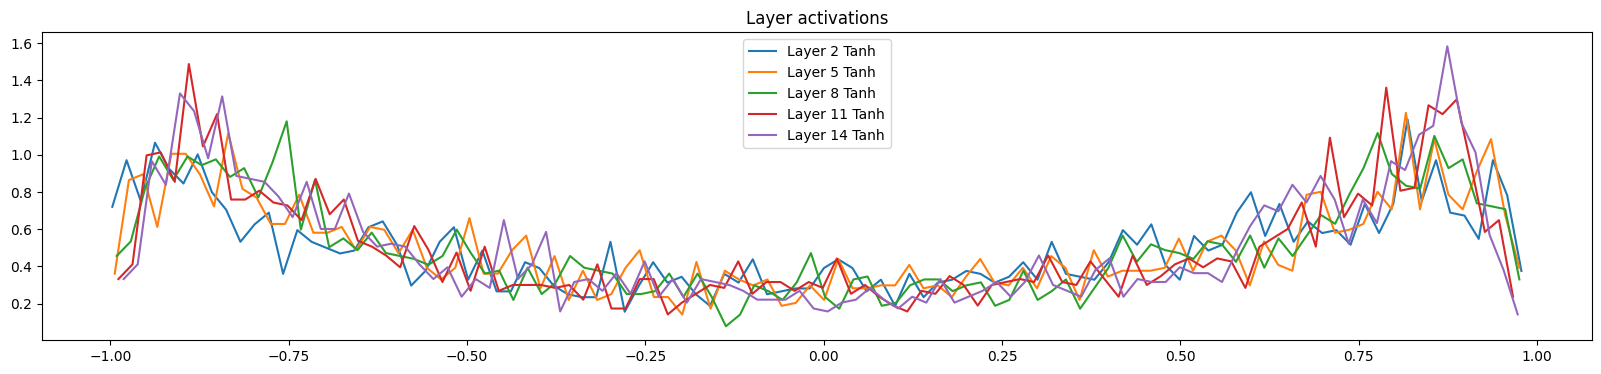

In [30]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f"Layer {i} {layer.__class__.__name__}: mean {t.mean():.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].cpu().detach(), hy.cpu().detach())
        legends.append(f"Layer {i} {layer.__class__.__name__}")
plt.legend(legends)
plt.title("Layer activations")


layer 2 (      Tanh): mean +0.000000, std 1.248108e-03
layer 5 (      Tanh): mean -0.000000, std 1.079529e-03
layer 8 (      Tanh): mean +0.000000, std 1.055438e-03
layer 11 (      Tanh): mean +0.000000, std 1.106833e-03
layer 14 (      Tanh): mean -0.000000, std 1.249399e-03


Text(0.5, 1.0, 'gradient distribution')

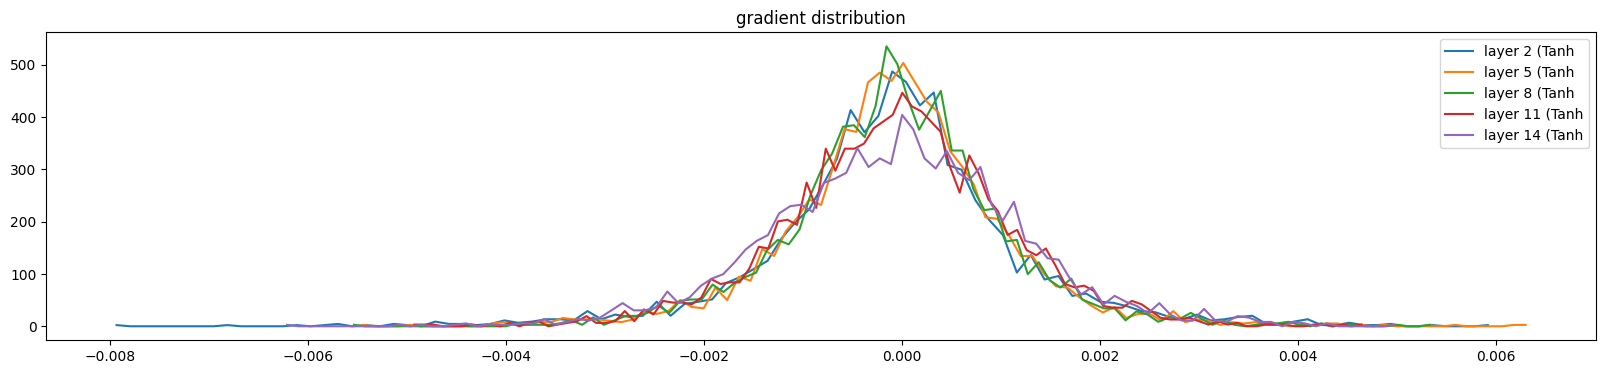

In [31]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].cpu().detach(), hy.cpu().detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

Weight (27, 10): mean -0.00, std 0.01, grad: data ratio 0.007239185273647308
Weight (30, 100): mean 0.00, std 0.00, grad: data ratio 0.017601002007722855
Weight (100, 100): mean -0.00, std 0.00, grad: data ratio 0.015859166160225868
Weight (100, 100): mean -0.00, std 0.00, grad: data ratio 0.01472072210162878
Weight (100, 100): mean -0.00, std 0.00, grad: data ratio 0.015000302344560623
Weight (100, 100): mean -0.00, std 0.00, grad: data ratio 0.01504792645573616
Weight (100, 27): mean -0.00, std 0.00, grad: data ratio 0.023786596953868866


Text(0.5, 1.0, 'Weights gradient distribution')

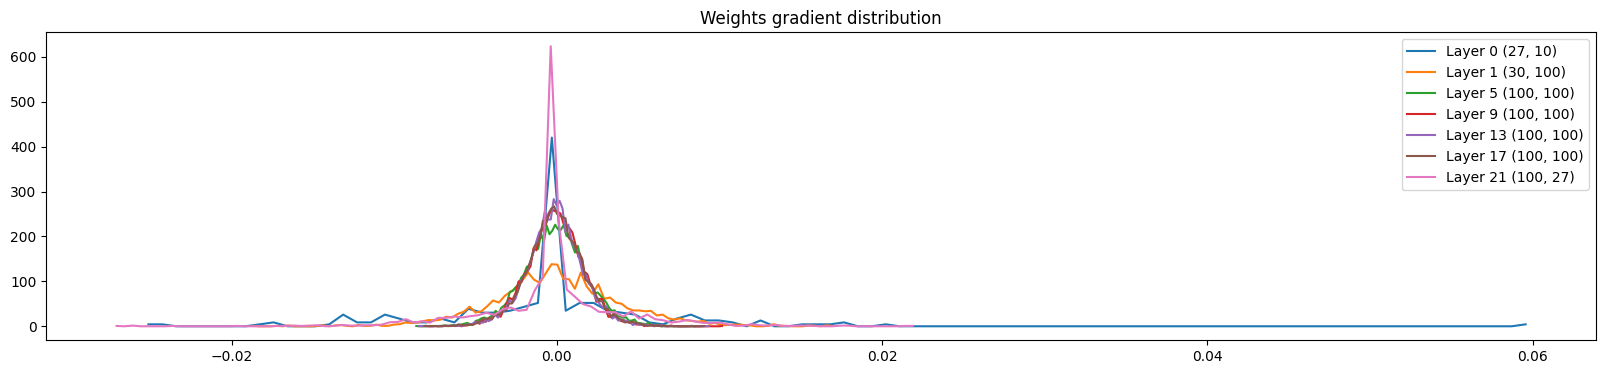

In [32]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            f"Weight {tuple(p.shape)}: mean {t.mean():.2f}, std {t.std():.2f}, grad: data ratio {t.std() / p.std()}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].cpu().detach(), hy.cpu().detach())
        legends.append(f"Layer {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Weights gradient distribution")


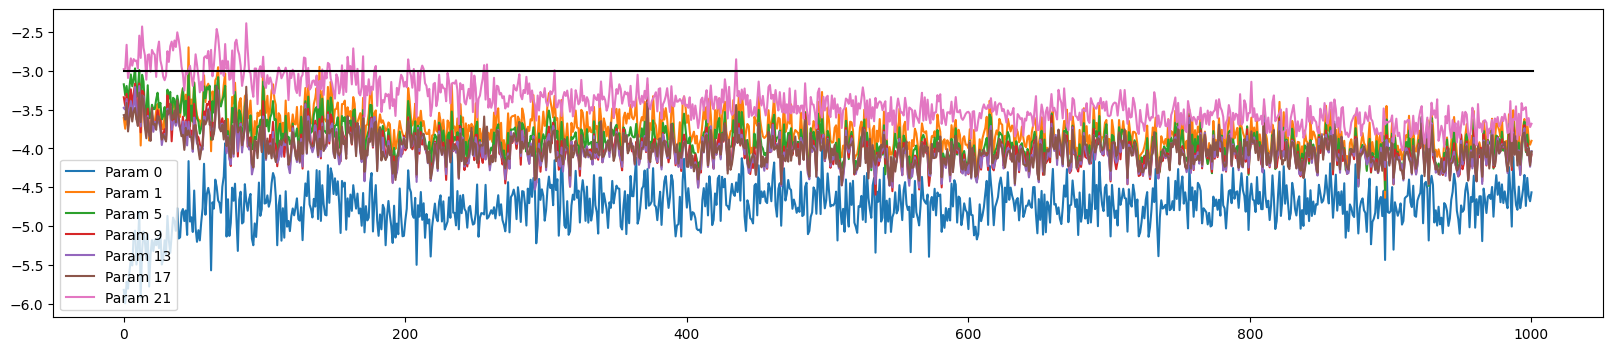

In [36]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"Param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)